In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', 50)

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.5
1.13.1


In [2]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [3]:
Grab = pd.read_csv('GrabAssignment.csv')

In [4]:
Grab.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [5]:
Grab.shape

(4206321, 4)

In [6]:
Grab.columns

Index(['geohash6', 'day', 'timestamp', 'demand'], dtype='object')

In [7]:
Grab.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
dtype: object

In [8]:
# Each day should have 96 timestamp (15 min), here to check out which day didnt have complete timestamp cycle
a_list = []
for c in range(1,61):
    lens = len(Grab[Grab["day"] == c].timestamp.value_counts())
    if lens != 96:
        a_list.append(c)
print(a_list)

[18]


In [9]:
#Regroup data to make the day and timestamp in order and unstack geohash
GrabFull = Grab.groupby(['geohash6', 'day', 'timestamp'])['demand'].mean().unstack('geohash6')

In [10]:
GrabFull.columns

Index(['qp02yc', 'qp02yf', 'qp02yu', 'qp02yv', 'qp02yy', 'qp02yz', 'qp02z1',
       'qp02z3', 'qp02z4', 'qp02z5',
       ...
       'qp0djv', 'qp0djw', 'qp0djy', 'qp0dn0', 'qp0dn1', 'qp0dn4', 'qp0dn5',
       'qp0dnh', 'qp0dnj', 'qp0dnn'],
      dtype='object', name='geohash6', length=1329)

In [11]:
# Creating the DataFrame to fillup the NaN value in Raw Data to complete timestamp cycle for timeseries forecasting
fillup_ts = pd.DataFrame(GrabFull.columns)
fillup_ts["day"] = 18
fillup_ts["demand"] = np.NaN

In [12]:
fillup_ts

,geohash6,day,demand
0,qp02yc,18,NaN
1,qp02yf,18,NaN
2,qp02yu,18,NaN
3,qp02yv,18,NaN
4,qp02yy,18,NaN
5,qp02yz,18,NaN
6,qp02z1,18,NaN
7,qp02z3,18,NaN
8,qp02z4,18,NaN
9,qp02z5,18,NaN


In [13]:
fillup_ts_str = pd.Series([str("9:45"),str("10:0"),str("10:15"),str("12:45"),str("11:30"),str("11:45"),str("12:0"),str("12:15"),str("12:30")])

In [14]:
fillup_ts_full = pd.DataFrame()
for ts in fillup_ts_str:
    fillup_ts["timestamp"] = ts
    fillup_ts_full = pd.concat([fillup_ts_full,fillup_ts], ignore_index=True)
    

In [15]:
fillup_ts_full

,geohash6,day,demand,timestamp
0,qp02yc,18,NaN,9:45
1,qp02yf,18,NaN,9:45
2,qp02yu,18,NaN,9:45
3,qp02yv,18,NaN,9:45
4,qp02yy,18,NaN,9:45
5,qp02yz,18,NaN,9:45
6,qp02z1,18,NaN,9:45
7,qp02z3,18,NaN,9:45
8,qp02z4,18,NaN,9:45
9,qp02z5,18,NaN,9:45


In [16]:
Grab_done = pd.concat([Grab,fillup_ts_full], ignore_index=True, sort=False)

In [17]:
Grab_done

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468
5,qp03tu,1,12:15,0.023843
6,qp096d,25,3:30,0.007460
7,qp03nr,51,20:45,0.000293
8,qp093r,48,6:15,0.054170
9,qp03r2,4,22:15,0.123463


In [18]:
Grab_done['timestamp'] = pd.to_datetime(Grab_done['timestamp'], format='%H:%M').dt.time

In [19]:
grab_train = Grab_done.groupby(['geohash6', 'day', 'timestamp'])['demand'].mean().unstack('geohash6')

In [20]:
grab_train.shape

(5856, 1329)

In [21]:
grab_train.isnull().sum().sum()

3576303

In [22]:
#Merge the consecutive day and timestamp into one time series with a assigned datetime and 15min frequency
grab_train = grab_train.set_index(pd.date_range(datetime(2019, 1, 1, hour=0, minute=0), periods=5856, freq='15min'))

In [23]:
grab_train = grab_train.fillna(0)

In [24]:
grab_train.head(10)

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,qp02z6,qp02z7,qp02z9,qp02zc,qp02zd,qp02ze,qp02zf,qp02zg,qp02zh,qp02zj,qp02zk,qp02zm,qp02zn,qp02zp,qp02zq,...,qp0djb,qp0djc,qp0djd,qp0dje,qp0djf,qp0djg,qp0djh,qp0djj,qp0djk,qp0djm,qp0djn,qp0djq,qp0djs,qp0djt,qp0dju,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.022396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.009482,0.0,0.000000,0.000000,0.003641,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0006,0.0,0.000000,0.000000,0.038979,0.000000,0.010554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.012865,0.000000,0.000000,0.0,0.001304,0.000000,0.002454,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.022022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.004910,0.000000,0.000000,0.0,0.020167,0.000000,0.000000,0.000000,0.0,0.000503,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
2019-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.070525,0.001295,0.000000,0.000000,0.008541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.001248,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.083947,0.000000,0.045482,0.047912,0.006503,0.000000,0.000000,0.000000,0.049005,0.047575,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.009687,0.000000,0.051739,0.0,0.010428,0.000000,0.000000,0.0,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0
2019-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.045083,0.000000,0.000000,0.031414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060752,0.000000,0.000000,...,0.0,0.0,0.011394,0.000000,0.000000,0.0,0.009599,0.017358,0.000000,0.000000,0.0,0.020719,0.000000,0.000000,0.0,0.0,0.0,0.006971,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.099317,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.048360,0.000954,0.000000,0.000000,0.000000,0.000000,0.000000,0.104351,0.075672,0.000630,0.066387,...,0.0,0.0,0.000000,0.000471,0.012844,0.0,0.027026,0.029316,0.007121,0.005744,0.0,0.000000,0.000993,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.019563,0.0
2019-01-01 01:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.011855,0.003631,0.000000,0.000000,0.039394,0.000000,0.000000,0.000000,0.000000,0.019048,0.036850,0.079985,0.055821,0.071413,...,0.0,0.0,0.000000,0.000000,0.003883,0.0,0.004794,0.000000,0.019596,0.031227,0.0,0.023070,0.000721,0.000000,0.0,0.0,0.0,0.001858,0.0,0.0,0.0,0.0,0.0,0.007193,0.0
2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.029813,0.0,0.0,0.0000,0.0,0.000000,0.045931,0.000000,0.000000,0.000000,0.000000,0.023930,0.000000,0.082367,0.000000,0.019131,0.022062,0.036493,0.012899,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.016685,0.024294,0.034116,0.018435,0.0,0.011025,0.005066,0.011381,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 02:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.099991,0.0,0.0,0.0000,0.0,0.019614,0.019863,0.000000,0.016487,0.000000,0.000000,0.044045,0.014075,0.237685,0.000000,0.042676,0.124104,0.038605,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000553,0.006702,0.032528,0.007979,0.0,0.000000,0.019812,0.002717,0.0,0.0,0.0,0.008936,0.0,0.0,0.0,0.0,0.0,0.007224,0.0


# PCA to 1D data

In [25]:
pca = PCA(n_components=1)

In [26]:
train_2D = pca.fit_transform(grab_train[0:-672])

In [27]:
pca.explained_variance_ratio_.sum()

0.6518035209822822

In [28]:
pca.explained_variance_ratio_

array([0.65180352])

In [29]:
train_2D = pd.DataFrame(data = train_2D, columns=["z1"])

In [30]:
train_2D = train_2D.set_index(pd.date_range(datetime(2019, 1, 1, hour=0, minute=0), periods=5184, freq='15min'))

In [31]:
train_2D.shape

(5184, 1)

# LSTM 1D Model, Train(5184) & Test(672), RMSE: 0.09162732

In [58]:
train = np.array(train_2D)
test = grab_train[-672:]

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [60]:
train.shape

(5184, 1)

In [61]:
# define generator
n_input = 96
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=4)

In [62]:
len(generator)

1272

In [63]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-2.40622459 -2.28458541 -2.13703857 -2.02532217 -1.80410301 -1.61874279
 -1.30060579 -1.1275598  -1.02096863 -0.79161778 -0.60927436 -0.51168278
  0.22711314  0.37109598  0.32536333  0.47689625  0.61403808  0.83857726
  0.84967034  0.85448193  0.85787965  0.87877939  0.95950805  1.10670086
  1.34944834  1.27249034  1.30180277  1.17095891  1.41855935  1.41140592
  1.52405215  1.73003932  1.89374743  1.81838011  1.78173187  1.72097091
  1.58340664  1.62855449  1.66989239  1.62433804  1.75844861  1.56529411
  1.55583555  1.64718182  1.61062626  1.5794046   1.47089492  1.54487396
  1.55998687  1.56066779  1.40345926  1.30038879  1.360757    1.40425931
  1.43925863  1.32617801  1.32548923  1.0015957   0.59836859  0.05540764
 -0.20315796 -0.7084081  -1.04637406 -1.28313899 -1.54421151 -1.85741243
 -2.13079264 -2.34321808 -2.54650173 -2.79195198 -2.95289758 -3.08780783
 -3.06911959 -3.21708608 -3.24916663 -3.37482    -3.3531664  -3.43575873
 -3.4795952  -3.49625008 -3.47790

In [67]:
# define model
model = Sequential()
model.add(LSTM(32,return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [68]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 96, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [69]:
# fit model
model.fit_generator(generator,epochs=2)

Epoch 1/2
1272/1272 [==============================] - 419s 329ms/step - loss: 0.3111
Epoch 2/2
1272/1272 [==============================] - 408s 321ms/step - loss: 0.0656


In [70]:
model.history.history.keys()

dict_keys(['loss'])

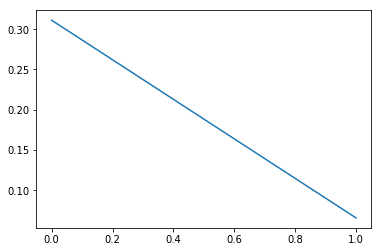

In [71]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [73]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [74]:
test_predictions

[array([-2.580463], dtype=float32),
 array([-2.4590933], dtype=float32),
 array([-2.3430982], dtype=float32),
 array([-2.2301774], dtype=float32),
 array([-2.1205606], dtype=float32),
 array([-2.0154893], dtype=float32),
 array([-1.9166014], dtype=float32),
 array([-1.8254542], dtype=float32),
 array([-1.743224], dtype=float32),
 array([-1.6705613], dtype=float32),
 array([-1.6075699], dtype=float32),
 array([-1.5538795], dtype=float32),
 array([-1.5087638], dtype=float32),
 array([-1.4712784], dtype=float32),
 array([-1.4403858], dtype=float32),
 array([-1.4150529], dtype=float32),
 array([-1.3943207], dtype=float32),
 array([-1.3773438], dtype=float32),
 array([-1.3634063], dtype=float32),
 array([-1.3519225], dtype=float32),
 array([-1.3424269], dtype=float32),
 array([-1.3345572], dtype=float32),
 array([-1.3280379], dtype=float32),
 array([-1.3226604], dtype=float32),
 array([-1.3182702], dtype=float32),
 array([-1.3147504], dtype=float32),
 array([-1.3120126], dtype=float32),
 ar

In [75]:
test

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,qp02z6,qp02z7,qp02z9,qp02zc,qp02zd,qp02ze,qp02zf,qp02zg,qp02zh,qp02zj,qp02zk,qp02zm,qp02zn,qp02zp,qp02zq,...,qp0djb,qp0djc,qp0djd,qp0dje,qp0djf,qp0djg,qp0djh,qp0djj,qp0djk,qp0djm,qp0djn,qp0djq,qp0djs,qp0djt,qp0dju,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
2019-02-24 00:00:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.029763,0.000000,0.000000,0.000000,0.000000,0.000000,0.016727,0.013015,0.000000,0.025116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019675,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.015878,0.000000,0.023531,0.000000,0.0,0.000000,0.000000,0.022647,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 00:15:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.054446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005864,0.059840,0.000000,0.013824,0.000000,0.000000,0.000000,0.011338,0.000000,0.049985,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003683,0.000000,0.032019,0.012283,0.0,0.000000,0.001958,0.005729,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 00:30:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.104589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005421,0.000000,0.111036,0.035332,0.000000,0.000000,0.034689,0.018911,0.050431,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.005074,0.000000,0.000000,0.024764,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 00:45:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.051767,0.014128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129767,0.049260,0.000000,0.000000,0.060142,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.031341,0.0,0.001891,0.000000,0.006809,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.005273,0.0
2019-02-24 01:00:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.006490,0.019285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064754,0.112054,0.000000,0.081648,0.044963,0.000000,0.000000,0.031515,0.011340,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.020983,0.000000,0.0,0.000000,0.018172,0.018921,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 01:15:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.036607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019613,0.185787,0.000000,0.060255,0.000000,0.000000,0.096981,0.004537,0.000000,0.011478,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.016881,0.010655,0.029784,0.078892,0.0,0.003420,0.004328,0.005414,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 01:30:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.034902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184562,0.040454,0.000000,0.000000,0.012627,0.000000,0.036833,0.019287,0.053435,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.031328,0.042781,0.023086,0.063003,0.0,0.034166,0.000000,0.004368,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 01:45:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.024704,0.000946,0.000000,0.000000,0.000000,0.000000,0.000000,0.056601,0.000000,0.009334,0.226620,0.040458,0.024467,0.044634,0.000000,0.074875,0.000000,0.008904,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.024596,0.056300,0.041478,0.0,0.030640,0.000000,0.000389,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 02:00:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.025118,0.000000,0.000000,0.000000,0.007215,0.000000,0.008171,0.034028,0.003310,0.059512,0.256225,0.000000,0.062125,0.091439,0.026766,0.108976,0.097004,0.101699,0.055418,...,0.0,0.000000,0.016204,0.000000,0.0,0.0,0.015678,0.017276,0.003908,0.017108,0.0,0.023939,0.000000,0.007389,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0
2019-02-24 02:15:00,0.000000,0.0,0.0,0.0,0.0,0.000000,0

In [76]:
test_predictions = pca.inverse_transform(test_predictions)

In [77]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=672, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [78]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test,test_predictions)))
print(mean_absolute_error(test,test_predictions)*100)
print(test.mean().sum())

0.09162732789489426
4.043047520069513
81.90959266258383


In [97]:
# Forecast for next 48 timestamp only to avoid error convergence
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [98]:
test_predictions = pca.inverse_transform(test_predictions)

In [99]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=48, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [100]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test[:48],test_predictions)))
print(mean_absolute_error(test[:48],test_predictions)*100)
print(test[:48].mean().sum())

0.07243782537331792
3.0539028080908652
80.70151569327078


# Saving and Loading Models

In [79]:
model.save('simple_LSTM_model.h5')

## Load a model

In [80]:
from keras.models import load_model
new_model = load_model('simple_LSTM_model.h5')

In [81]:
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 96, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


# LSTM PCA > 5D model, Train(5184) & Test(672), RMSE: 0.08921334

In [101]:
pca = PCA(n_components=5)

In [102]:
train_2D = pca.fit_transform(grab_train[0:-672])

In [103]:
pca.explained_variance_ratio_.sum()

0.8085070179723173

In [104]:
pca.explained_variance_ratio_

array([0.65180352, 0.06130845, 0.04398342, 0.02706075, 0.02435087])

In [106]:
train_2D = pd.DataFrame(data = train_2D, columns=["z1","z2","z3","z4","z5"])

In [107]:
train_2D = train_2D.set_index(pd.date_range(datetime(2019, 1, 1, hour=0, minute=0), periods=5184, freq='15min'))

In [108]:
train_2D.shape

(5184, 5)

In [109]:
train = np.array(train_2D)
test = grab_train[-672:]

In [110]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [111]:
train.shape

(5184, 5)

In [112]:
# define generator
n_input = 96
n_features = 5
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=4)

In [113]:
len(generator)

1272

In [114]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-2.40622459  0.10796683  0.15824195 ...  1.11812705 -0.07195214
 -1.18641737]
Predict this y: 
 [[ 0.44321708  1.32428059  0.86678678 -0.18189724 -1.00119392]
 [ 0.7023547   1.32512056  0.88093134 -0.16695222 -1.03916941]
 [ 0.96212352  1.2695897   1.11812705 -0.07195214 -1.18641737]
 [ 1.09596591  1.10515536  1.20161717 -0.05917027 -1.07279854]]


In [118]:
# define model
model = Sequential()
model.add(LSTM(32,return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(32))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse')

In [119]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 96, 32)            4864      
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 13,349
Trainable params: 13,349
Non-trainable params: 0
_________________________________________________________________


In [121]:
# fit model
model.fit_generator(generator,epochs=2)

Epoch 1/2
1272/1272 [==============================] - 323s 254ms/step - loss: 0.0874
Epoch 2/2
1272/1272 [==============================] - 385s 302ms/step - loss: 0.0435


In [122]:
model.history.history.keys()

dict_keys(['loss'])

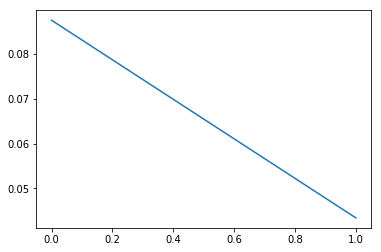

In [123]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [131]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(672):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [127]:
test_predictions

[array([-2.5839992 , -0.1361793 ,  0.21703355, -0.08867142,  0.24121451],
       dtype=float32),
 array([-2.4308898 , -0.10755396,  0.26806542, -0.10880135,  0.20863925],
       dtype=float32),
 array([-2.2797925 , -0.08394877,  0.31813982, -0.12851597,  0.18011594],
       dtype=float32),
 array([-2.1237535 , -0.06614847,  0.37213907, -0.14699842,  0.15301241],
       dtype=float32),
 array([-1.9595661 , -0.05503307,  0.431608  , -0.16412884,  0.1268429 ],
       dtype=float32),
 array([-1.7866414 , -0.05153143,  0.49641952, -0.1800725 ,  0.10205217],
       dtype=float32),
 array([-1.6059903 , -0.05652832,  0.565305  , -0.19499078,  0.07959437],
       dtype=float32),
 array([-1.4197788 , -0.07070712,  0.63612616, -0.20896722,  0.06066525],
       dtype=float32),
 array([-1.2309983 , -0.09438375,  0.7061259 , -0.22200271,  0.04647551],
       dtype=float32),
 array([-1.0430756 , -0.12738296,  0.7722498 , -0.23402473,  0.03799872],
       dtype=float32),
 array([-0.85942644, -0.169011

In [132]:
test_predictions = pca.inverse_transform(test_predictions)

In [134]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=672, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [136]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test,test_predictions)))
print(mean_absolute_error(test,test_predictions)*100)
print(test.mean().sum())

0.08921334353785106
3.9323969684377054
81.90959266258383


In [137]:
# Forecast for next 48 timestamp only to avoid error convergence
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [138]:
test_predictions = pca.inverse_transform(test_predictions)

In [139]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=48, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [140]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test[:48],test_predictions)))
print(mean_absolute_error(test[:48],test_predictions)*100)
print(test[:48].mean().sum())

0.04268090604046894
2.0308422881864425
80.70151569327078


# LSTM 117D model, PCA retained 95% Variation, Train(5184) & Test(672), RMSE: 0.10279505

In [141]:
pca = PCA(0.95)

In [142]:
train_2D = pca.fit_transform(grab_train[0:-672])

In [143]:
pca.explained_variance_ratio_.sum()

0.9501405036970398

In [144]:
pca.explained_variance_ratio_

array([6.51803521e-01, 6.13084516e-02, 4.39834237e-02, 2.70607501e-02,
       2.43508716e-02, 1.75100875e-02, 1.29762158e-02, 8.40748785e-03,
       6.61011213e-03, 6.24463943e-03, 4.81676383e-03, 4.72410334e-03,
       3.87567708e-03, 3.64940584e-03, 3.12047035e-03, 2.69894027e-03,
       2.48680843e-03, 2.22087156e-03, 2.08501822e-03, 2.01848902e-03,
       1.88598121e-03, 1.63494691e-03, 1.52169704e-03, 1.50807216e-03,
       1.41445432e-03, 1.32655326e-03, 1.28530012e-03, 1.20351730e-03,
       1.16560559e-03, 1.12709808e-03, 1.10392382e-03, 1.06164220e-03,
       9.99131901e-04, 9.80129237e-04, 9.58076150e-04, 9.36822241e-04,
       8.99536398e-04, 8.77785092e-04, 8.50523352e-04, 8.15951215e-04,
       7.82523108e-04, 7.78746326e-04, 7.59420882e-04, 7.41447503e-04,
       7.20550428e-04, 7.11871780e-04, 6.90015780e-04, 6.76431463e-04,
       6.67984519e-04, 6.57261678e-04, 6.38505613e-04, 6.21709019e-04,
       6.09059280e-04, 5.98429760e-04, 5.90245775e-04, 5.80509339e-04,
      

In [145]:
train_2D = pd.DataFrame(data = train_2D)

In [146]:
train_2D = train_2D.set_index(pd.date_range(datetime(2019, 1, 1, hour=0, minute=0), periods=5184, freq='15min'))

In [147]:
train_2D.shape

(5184, 117)

In [148]:
train = np.array(train_2D)
test = grab_train[-672:]

In [149]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [150]:
train.shape

(5184, 117)

In [159]:
# define generator
n_input = 96
n_features = 117
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=4)

In [152]:
len(generator)

1272

In [153]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-2.40622459  0.10796683  0.15824195 ... -0.05302298 -0.02920606
  0.04672191]
Predict this y: 
 [[ 4.43217077e-01  1.32428059e+00  8.66786780e-01 -1.81897234e-01
  -1.00119393e+00  3.87860870e-01  1.16451652e-01 -1.61014074e-01
  -1.45901711e-02  1.23522329e-01  5.61847408e-02  1.47760594e-01
  -8.35608467e-02 -6.33895964e-02  3.63706829e-02  3.15933007e-02
  -1.53199779e-01  2.09077522e-01  7.78239510e-02  7.48643617e-02
  -1.12957554e-01  1.34689479e-01 -6.34980816e-03 -4.96733207e-02
  -5.64863293e-02  1.42943981e-02 -7.77263701e-02 -2.67541838e-02
  -5.30332092e-02 -6.14826475e-02  7.55036834e-02  4.27109715e-02
   1.07182481e-01  1.50921575e-01  4.41781218e-02 -3.31585162e-02
  -1.01391834e-01  8.48239900e-02 -9.44290104e-02 -7.97369770e-02
   2.77151537e-02  2.57379988e-02 -1.31616382e-01  1.71675981e-02
   5.94972255e-02  7.29596746e-03 -1.92153025e-02  6.67133188e-02
  -2.14942264e-02 -1.58193654e-02 -1.11942803e-01  3.28937869e-02
  -9.24882228e-02  1.254040

In [160]:
# define model
model = Sequential()
model.add(LSTM(32,return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(32))
model.add(Dense(117))
model.compile(optimizer='adam', loss='mse')

In [161]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 96, 32)            19200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 117)               3861      
Total params: 31,381
Trainable params: 31,381
Non-trainable params: 0
_________________________________________________________________


In [162]:
# fit model
model.fit_generator(generator,epochs=2)

Epoch 1/2
1272/1272 [==============================] - 350s 275ms/step - loss: 0.0164
Epoch 2/2
1272/1272 [==============================] - 404s 318ms/step - loss: 0.0088


In [163]:
model.history.history.keys()

dict_keys(['loss'])

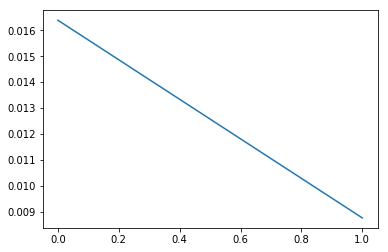

In [164]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [165]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(672): # range(len(test))
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [166]:
test_predictions

[array([-2.55633068e+00, -3.54099870e-02,  2.78605700e-01, -1.46801099e-01,
         1.26003265e-01,  3.54303360e-01,  9.23798904e-02, -5.17910011e-02,
         6.98283017e-02,  1.87501431e-01, -6.18477203e-02, -1.94365755e-02,
        -5.28443754e-02,  3.42303403e-02,  4.45389654e-03,  1.38270166e-02,
         1.67530067e-02, -2.72932630e-02,  4.57974672e-02,  1.62847061e-02,
        -1.61412824e-02,  2.70949937e-02,  5.61042950e-02, -2.09237188e-02,
        -7.56101683e-04,  1.71787757e-02,  6.34697918e-03, -4.12103347e-02,
         2.51784250e-02, -4.20893030e-03,  1.23982877e-03, -1.32394005e-02,
         1.35153588e-02,  2.74735913e-02, -2.14330517e-02,  1.59825943e-02,
         2.30096444e-03, -2.45085433e-02, -4.71264981e-02,  8.47446173e-03,
        -1.68597605e-02,  5.63055556e-03,  3.05148326e-02,  7.28651136e-03,
         1.57929882e-02,  1.68945314e-03,  7.47063709e-03,  1.20478813e-02,
         6.39063772e-04,  1.19610745e-02,  2.71327719e-02, -2.32118415e-03,
         1.1

In [167]:
test_predictions = pca.inverse_transform(test_predictions)

In [168]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=672, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [169]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test,test_predictions)))
print(mean_absolute_error(test,test_predictions)*100)
print(test.mean().sum())

0.10279505088095804
4.634477595811135
81.90959266258383


In [170]:
# Forecast for next 48 timestamp only to avoid error convergence
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [171]:
test_predictions = pca.inverse_transform(test_predictions)

In [172]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=48, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [173]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test[:48],test_predictions)))
print(mean_absolute_error(test[:48],test_predictions)*100)
print(test[:48].mean().sum())

0.04750162510209827
2.345619583499351
80.70151569327078


# LSTM model with Original Dimension, Train(5184) & Test(672), RMSE: 0.08371820

In [174]:
train = np.array(grab_train[:-672])
test = grab_train[-672:]

In [175]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [176]:
train.shape

(5184, 1329)

In [177]:
# define generator
n_input = 96
n_features = 1329
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=4)

In [178]:
len(generator)

1272

In [153]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-2.40622459  0.10796683  0.15824195 ... -0.05302298 -0.02920606
  0.04672191]
Predict this y: 
 [[ 4.43217077e-01  1.32428059e+00  8.66786780e-01 -1.81897234e-01
  -1.00119393e+00  3.87860870e-01  1.16451652e-01 -1.61014074e-01
  -1.45901711e-02  1.23522329e-01  5.61847408e-02  1.47760594e-01
  -8.35608467e-02 -6.33895964e-02  3.63706829e-02  3.15933007e-02
  -1.53199779e-01  2.09077522e-01  7.78239510e-02  7.48643617e-02
  -1.12957554e-01  1.34689479e-01 -6.34980816e-03 -4.96733207e-02
  -5.64863293e-02  1.42943981e-02 -7.77263701e-02 -2.67541838e-02
  -5.30332092e-02 -6.14826475e-02  7.55036834e-02  4.27109715e-02
   1.07182481e-01  1.50921575e-01  4.41781218e-02 -3.31585162e-02
  -1.01391834e-01  8.48239900e-02 -9.44290104e-02 -7.97369770e-02
   2.77151537e-02  2.57379988e-02 -1.31616382e-01  1.71675981e-02
   5.94972255e-02  7.29596746e-03 -1.92153025e-02  6.67133188e-02
  -2.14942264e-02 -1.58193654e-02 -1.11942803e-01  3.28937869e-02
  -9.24882228e-02  1.254040

In [179]:
# define model
model = Sequential()
model.add(LSTM(32,return_sequences = True, input_shape=(n_input, n_features)))
model.add(LSTM(32))
model.add(Dense(1329))
model.compile(optimizer='adam', loss='mse')

In [180]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 96, 32)            174336    
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_13 (Dense)             (None, 1329)              43857     
Total params: 226,513
Trainable params: 226,513
Non-trainable params: 0
_________________________________________________________________


In [181]:
# fit model
model.fit_generator(generator,epochs=2)

Epoch 1/2
1272/1272 [==============================] - 595s 468ms/step - loss: 0.0021
Epoch 2/2
1272/1272 [==============================] - 590s 464ms/step - loss: 0.0013


In [182]:
model.history.history.keys()

dict_keys(['loss'])

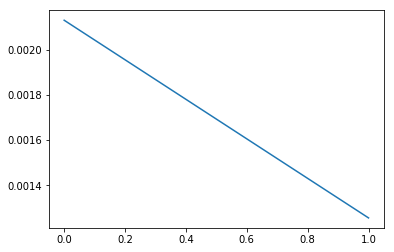

In [183]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [184]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(672): # range(len(test))
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [185]:
test_predictions

[array([-0.00143891,  0.00105779, -0.00207995, ...,  0.00105619,
         0.01463159,  0.00220226], dtype=float32),
 array([-0.00125354,  0.00160321, -0.00211479, ...,  0.0008076 ,
         0.01614825,  0.00240904], dtype=float32),
 array([-0.00107631,  0.00232515, -0.00213095, ...,  0.00060136,
         0.0179221 ,  0.00270627], dtype=float32),
 array([-0.00080481,  0.00306138, -0.00219104, ...,  0.00046168,
         0.01981349,  0.00306092], dtype=float32),
 array([-0.00041795,  0.00375544, -0.00228714, ...,  0.00041517,
         0.0217551 ,  0.00343643], dtype=float32),
 array([ 8.0546830e-05,  4.3094987e-03, -2.3956154e-03, ...,
         5.2202214e-04,  2.3651775e-02,  3.7798039e-03], dtype=float32),
 array([ 0.00067479,  0.00462438, -0.00250701, ...,  0.00083322,
         0.02540722,  0.00403472], dtype=float32),
 array([ 0.00133722,  0.00465698, -0.00264354, ...,  0.00134669,
         0.02698328,  0.00416518], dtype=float32),
 array([ 0.00204367,  0.00438592, -0.00282354, ...,  0

In [187]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=672, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [188]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test,test_predictions)))
print(mean_absolute_error(test,test_predictions)*100)
print(test.mean().sum())

0.08371820717110798
4.070083966875646
81.90959266258383


In [189]:
# Forecast for next 48 timestamp only to avoid error convergence
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [190]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=48, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [191]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test[:48],test_predictions)))
print(mean_absolute_error(test[:48],test_predictions)*100)
print(test[:48].mean().sum())

0.04486445795617721
2.2708079672983668
80.70151569327078


# Forecasting for next 5 timestamps only

In [192]:
# Forecast for next 48 timestamp only to avoid error convergence
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(5):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [193]:
#Set the time frame to be same as test dataset
idxH_F_Exo = pd.date_range(datetime(2019, 2, 24, hour=0, minute=0), periods=5, freq='15min')

#Modify variable z to be a data frame and have the same time frame and columns with the test dataset rather than a array
test_predictions = pd.DataFrame(test_predictions, index=idxH_F_Exo, columns=test.columns)

In [194]:
#The RMSE for the forecasted values and test dataset
print(np.sqrt(mean_squared_error(test[:5],test_predictions)))
print(mean_absolute_error(test[:5],test_predictions)*100)
print(test[:5].mean().sum())

0.02361586555914137
1.3107572030881751
38.4979369284623
